In [3]:
!git init .
!git remote add origin https://github.com/VladKriuch/ML-Unlearning.git
!git pull origin master

remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 25 (delta 6), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (25/25), 6.35 KiB | 929.00 KiB/s, done.
From https://github.com/VladKriuch/ML-Unlearning
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

In [4]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [38]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# Choose random forget indecies from cars
forget_idx = np.random.choice(np.where(np.array(train_set.targets) == 1)[0], 200)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

Files already downloaded and verified
Files already downloaded and verified


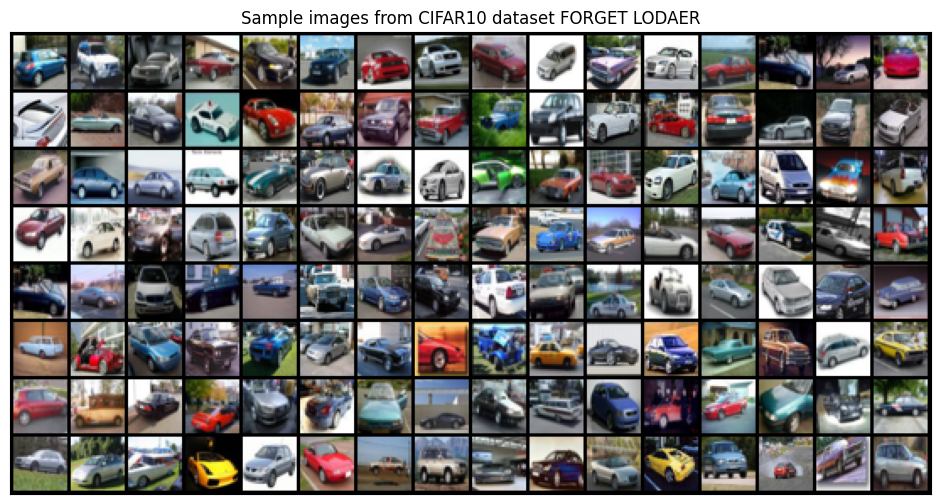

In [40]:
images, labels = next(iter(forget_loader))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset FORGET LOADER")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

Files already downloaded and verified


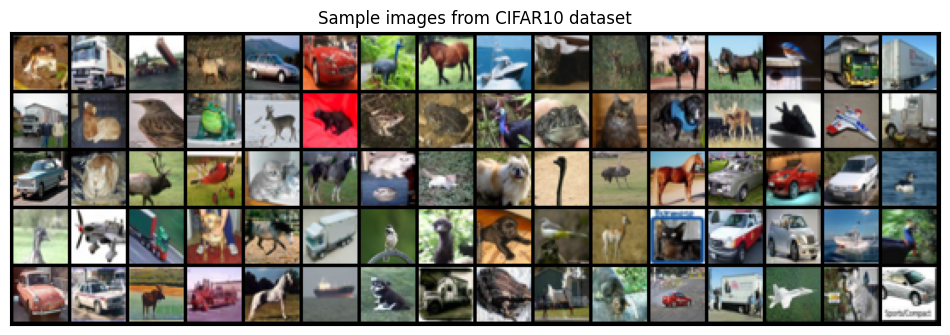

In [41]:
# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()